# Third Assignment

For this assignment you will have to identify a suitable dataset and implement a machine learning pipeline, comprising the following steps:

* Presentation of the problem (6 points)
* data exploration (4 points)
* data preparation (10 points)
* model selection: try 2 models (max 3) (20 points)
* evaluation on test set (3 points)
* conclusion commenting on the results and comparing the models (7 points)

**Total: 50 points**

**Submission:** Please email your solutions and your completed Declaration of Authorship (DoA) form to weeklyclasses@conted.ox.ac.uk 

## Regression Project for Movie Revenue Prediction

## Presentation of the problem



We will be looking at the 'tmdb_5000_movies.csv' dataset and trying to predict the revenue generated by the movie using a multivariate regression model. We will take our dataset and clean it by removing superflous information, removing blank rows, and checking that any data in the dataset makes sense, and removing any outliers that can could skew our predictions

Our dataset can be found at https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv

### Data exploration

In [1]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

# Statistical analysis and testing
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
movie_df = pd.read_csv('tmdb_5000_movies.csv')
movie_df.sample(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4658,0,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",NaN,150211,"[{""id"": 177972, ""name"": ""bickering""}, {""id"": 2...",en,The Frozen,"After a harrowing snowmobile accident, a young...",1.084,[],[],2012-10-10,0,0.000,[],Released,NaN,The Frozen,4.200,14
1877,25485000,"[{""id"": 36, ""name"": ""History""}, {""id"": 28, ""na...",NaN,11165,"[{""id"": 233, ""name"": ""japan""}, {""id"": 1956, ""n...",en,Tora! Tora! Tora!,"In the summer of 1941, the United States and J...",9.796,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}, {""iso_...",1970-01-26,29548291,144.000,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The incredible attack on Pearl Harbor.,Tora! Tora! Tora!,6.900,147
713,60000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,547,"[{""id"": 128, ""name"": ""love triangle""}, {""id"": ...",en,The Horse Whisperer,Based on the novel by the same name from Nicho...,12.867,"[{""name"": ""Wildwood Enterprises"", ""id"": 316}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1998-05-14,186883563,170.000,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,The Horse Whisperer,6.700,292


In [3]:
movie_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [4]:
movie_df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

In [5]:
movie_df.shape[0]

4803

In [6]:
movie_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.000,4803.000,4803.000,4803.000,4801.000,4803.000,4803.000
mean,29045039.875,57165.484,21.492,82260638.652,106.876,6.092,690.218
std,40722391.259,88694.614,31.817,162857100.943,22.612,1.195,1234.586
min,0.000,5.000,0.000,0.000,0.000,0.000,0.000
25%,790000.000,9014.500,4.668,0.000,94.000,5.600,54.000
50%,15000000.000,14629.000,12.922,19170001.000,103.000,6.200,235.000
75%,40000000.000,58610.500,28.314,92917187.000,118.000,6.800,737.000
max,380000000.000,459488.000,875.581,2787965087.000,338.000,10.000,13752.000


Looking at these pieces of information we can spot a few things, firstly that we have a lot of extra columns that we will not use in predicting revenue, thus we will only keep the columns 'budget', 'popularity', 'spoken_languages', 'vote_average', 'vote_count', 'runtime', and 'release_date' for now, and we will be using the 'revenue' column as what we are predicting.

We will convert 'spoken_languages' into ordinal data so our model can process this to make predictions. We will also extract the year value from 'release_date' so we can use this value also.

Looking at the information provided by the describe functions we can see that for some movies we have 'vote_count', 'runtime' or 'popularity' score of 0. These extreme values are likely to be erraneous or poorly sampled data - so we will clean these, as well as any null values.

## Data preparation

#### Filtering numerical data

In [7]:
movie_columns = ['popularity', 'budget', 'spoken_languages', 'vote_count', 'vote_average', 'revenue', 'runtime','release_date']
clean_movie_df = movie_df[movie_columns]

clean_movie_df = clean_movie_df[
    (clean_movie_df['popularity'] != 0) &
    (clean_movie_df['runtime'] != 0) &
    (clean_movie_df['vote_count'] != 0)
]

We also want to sample movies where the 'vote_average' metric is an accurate reflection of the movie, thus we will also impose the condition where 'vote_count' is greater than or equal to 10, so to ensure that a sufficient number of people have rated the movie

In [8]:
clean_movie_df = clean_movie_df[(clean_movie_df['vote_count'] > 9) ]

In [9]:
clean_movie_df['year'] = pd.to_datetime(clean_movie_df['release_date']).dt.year

In [10]:
rows_with_nulls = clean_movie_df[clean_movie_df.isnull().any(axis=1)]
rows_with_nulls.head()

,popularity,budget,spoken_languages,vote_count,vote_average,revenue,runtime,release_date,year
2656,0.739,15000000,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",12,7.300,0,NaN,2015-12-03,2015


We have one null value so will use simply drop this row for simplicity.

In [11]:
clean_movie_df = clean_movie_df.dropna()

In [12]:
clean_movie_df.describe()

,popularity,budget,vote_count,vote_average,revenue,runtime,year
count,4386.000,4386.000,4386.000,4386.000,4386.000,4386.000,4386.000
mean,23.479,31684406.536,755.455,6.229,90032689.910,108.554,2002.269
std,32.604,41641989.718,1272.839,0.892,168369224.002,20.705,12.360
min,0.012,0.000,10.000,1.900,0.000,25.000,1916.000
25%,6.540,2917507.750,84.000,5.700,20785.000,95.000,1999.000
50%,14.838,17000000.000,290.000,6.300,27073347.500,105.000,2005.000
75%,30.294,42000000.000,831.750,6.800,102344508.000,119.000,2010.000
max,875.581,380000000.000,13752.000,8.500,2787965087.000,338.000,2016.000


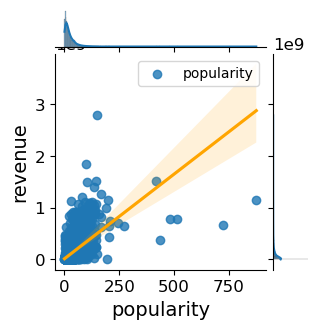

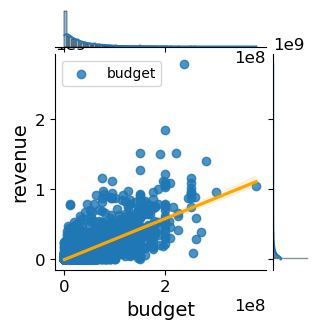

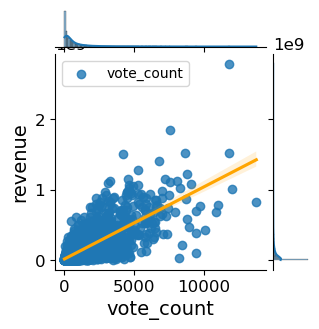

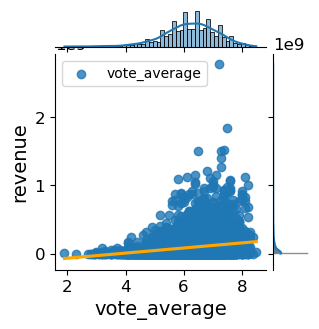

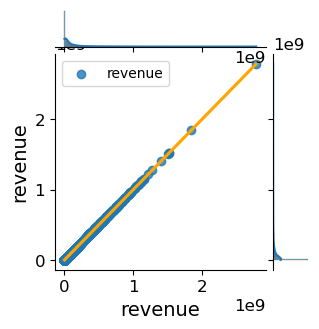

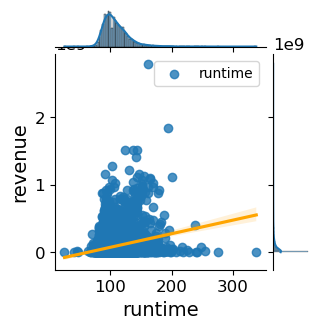

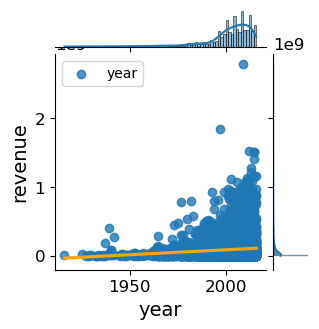

In [13]:
for feat in clean_movie_df.select_dtypes(include=['number']).columns:
    sns.jointplot(
        x=feat,
        y="revenue",
        data=clean_movie_df,
        kind='reg',
        label=feat,
        joint_kws={'line_kws':{'color':'orange'}}
    ).fig.set_size_inches(3, 3)
    plt.legend()
    plt.show()

Looking at these diagrams we see 'vote_count' and 'budget' seem to be the most strongly correlated with revenue, and so we will use these in our regression. 'popularity' and 'runtime' seem to be very clustered metrics offering limited information, so we will drop these from our dataset.

In [14]:
clean_movie_df.drop(columns=['popularity','runtime'], inplace= True)

#### Creating our ordinal data

For 'spoken_languages' we will be looking to convert this into an 'is_english_language' column where 1 represents yes and 0 represents no. 

For 'release_date' we will specify the decade the film was released, for example '1992-09-02' would get mapped to 1990.

In [15]:
import ast

def extract_language(spoken_language_str):
    
    spoken_language_list = ast.literal_eval(spoken_language_str)
    
    if spoken_language_list and 'name' in spoken_language_list[0]:
        return spoken_language_list[0]['name']
    return 'Unknown'

In [16]:
clean_movie_df['language_name'] = clean_movie_df['spoken_languages'].apply(extract_language)

clean_movie_df['is_english_language'] = (clean_movie_df['language_name'] == 'English').astype(int)

In [17]:
clean_movie_df.drop(columns=['spoken_languages','release_date','language_name'], inplace= True)
clean_movie_df.sample(4)

,budget,vote_count,vote_average,revenue,year,is_english_language
803,57000000,535,6.400,115267375,1996,1
1737,28000000,640,5.500,16374328,2016,1
1421,35000000,81,6.100,0,1992,1
1762,27000000,828,7.200,27200316,1998,1


In [18]:
def print_boxplot(
    data_set: pd.DataFrame,
    feature: str, 
    xlabels_rotation: int = None
):
    figsize=(14, 16)
    
    chart = sns.boxplot(x= feature, y='revenue' ,data = data_set, palette='rainbow')
    
    if xlabels_rotation is not None:
        chart.set_xticklabels(chart.get_xticklabels(), rotation=xlabels_rotation, horizontalalignment='center')

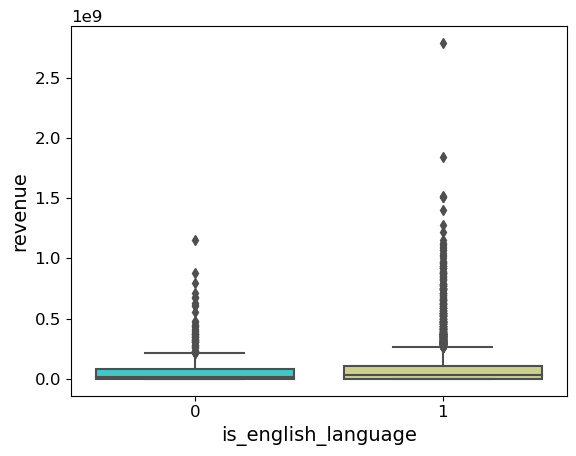

In [19]:
print_boxplot(clean_movie_df, 'is_english_language')

The english language metric does not seem to produce a distinguishable result, so we will drop this from our dataframe.

In [20]:
clean_movie_df.drop(columns= 'is_english_language', inplace= True)

#### Outliers

In [21]:
clean_movie_df.describe()

,budget,vote_count,vote_average,revenue,year
count,4386.000,4386.000,4386.000,4386.000,4386.000
mean,31684406.536,755.455,6.229,90032689.910,2002.269
std,41641989.718,1272.839,0.892,168369224.002,12.360
min,0.000,10.000,1.900,0.000,1916.000
25%,2917507.750,84.000,5.700,20785.000,1999.000
50%,17000000.000,290.000,6.300,27073347.500,2005.000
75%,42000000.000,831.750,6.800,102344508.000,2010.000
max,380000000.000,13752.000,8.500,2787965087.000,2016.000


Looking at our describe function we can see that we have unusually high figures for revenue which look like outliers, so lets take a look at the values more than three standard deviations out from the mean.

In [22]:
mean_revenue = clean_movie_df['revenue'].mean()
std_revenue = clean_movie_df['revenue'].std()

# Define the thresholds
lower_threshold = mean_revenue - 3 * std_revenue
upper_threshold = mean_revenue + 3 * std_revenue

# Filter the DataFrame
outliers = clean_movie_df[(clean_movie_df['revenue'] < lower_threshold) | (clean_movie_df['revenue'] > upper_threshold)]

In [23]:
outliers.shape[0] / clean_movie_df.shape[0]

0.024623803009575923

In [24]:
outliers['revenue'].describe()

count          108.000
mean     868820171.667
std      290734000.540
min      599045960.000
25%      693837708.000
50%      789023165.000
75%      944256599.000
max     2787965087.000
Name: revenue, dtype: float64

Even this minimum value of 599,045,960 is likely to skew our regression predictions, so we will remove these values from our dataset

In [25]:
clean_movie_df = clean_movie_df[(clean_movie_df['revenue'] >= lower_threshold) & (clean_movie_df['revenue'] <= upper_threshold)]

In [26]:
clean_movie_df.reset_index(inplace=True, drop=True)

#### Creating our testing and training data: scaling and separation

Now we will create a new column called 'budget_category' and will split each budget into one of five categories, so that when we come to split our set into testing and training we can have an equal distribution in both.

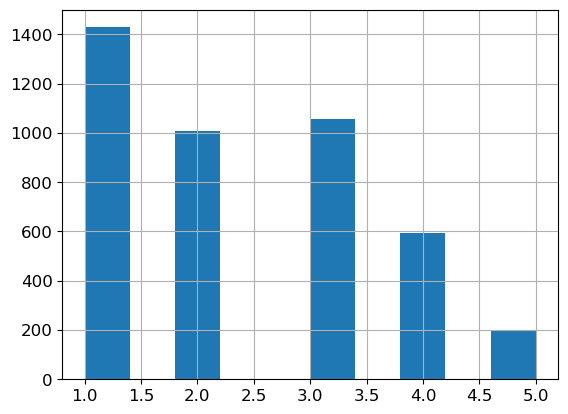

In [28]:
clean_movie_df['budget_categories'] = pd.cut(
    clean_movie_df.budget,
    bins = [-1., 6000000., 20000000., 50000000., 100000000., np.inf],
    labels=[1, 2, 3, 4, 5]
)

clean_movie_df['budget_categories'].hist()
plt.show()

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(clean_movie_df, clean_movie_df['budget_categories']):
    train_set = clean_movie_df.loc[train_index]
    test_set = clean_movie_df.loc[test_index]

We can now remove the 'budget_category' column from our test and train sets

In [30]:
for set_ in (train_set, test_set):
    set_.drop('budget_categories', axis=1, inplace=True)

In [31]:
train_set.describe()

,budget,vote_count,vote_average,revenue,year
count,3422.000,3422.000,3422.000,3422.000,3422.000
mean,28483450.060,640.209,6.214,70471024.990,2001.945
std,35349448.862,987.279,0.891,105398502.601,12.585
min,0.000,10.000,1.900,0.000,1916.000
25%,2500000.000,81.000,5.700,7901.500,1998.000
50%,16000000.000,278.000,6.300,24916953.500,2005.000
75%,40000000.000,750.750,6.800,96100842.250,2010.000
max,260000000.000,10099.000,8.500,591794936.000,2016.000


## Model selection

In order to predict movie revenue we will be using regression models, specifically a closed form linear regression model, a Stochastic gradient descent linear regression model, and a polynomial regression model and evaluating their performance. Firstly we need to define our training, testing and validation sets that we are going to pass through our models.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler().set_output(transform="pandas"))
])

column_transformer = ColumnTransformer(
    (
        ("numerical", num_pipeline, train_set.columns),
        ("categorical", OneHotEncoder(categories='auto', sparse_output=False).set_output(transform="pandas"), []),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

train_data_prepared = column_transformer.fit_transform(train_set).drop(columns = 'revenue')
test_data_prepared = column_transformer.fit_transform(test_set).drop(columns = 'revenue')

train_data_prepared = pd.concat([train_data_prepared, train_set['revenue']], axis=1)
test_data_prepared = pd.concat([test_data_prepared, test_set['revenue']], axis=1)

In [33]:
X_train = train_data_prepared.drop(columns ='revenue')
y_train = train_data_prepared['revenue']

X_test = test_data_prepared.drop(columns = 'revenue')
y_test = test_data_prepared['revenue']

#### Closed form linear regression model

In [34]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

#### Stochastic gradient descent linear regression model

In [35]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    loss="squared_error", # default cost function (MSE)
    max_iter=2000,   # max numer of epochs. epoch = 1 full iteration over the training set
    penalty=None,
    eta0=1e-3,  # initial learning rate
    tol=1e-3,   # stopping criterion tolerance
    random_state=77
)

sgd_reg.fit(X_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(eta0=0.001, max_iter=2000, penalty=None, random_state=77)

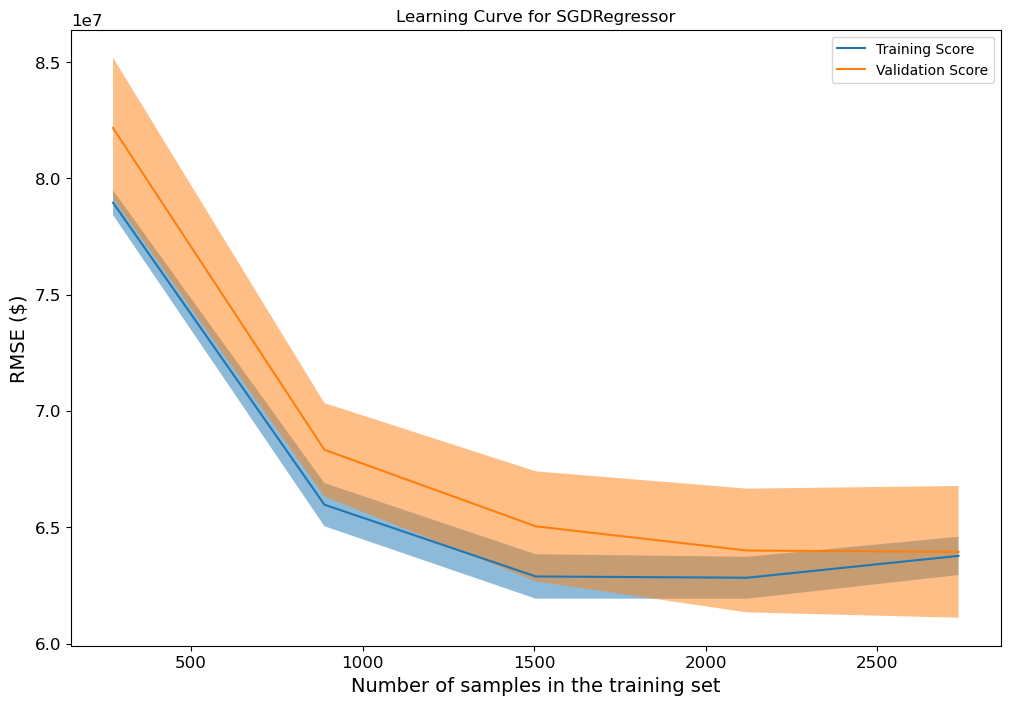

In [36]:
from sklearn.model_selection import LearningCurveDisplay

fig, ax = plt.subplots(figsize=(12, 8))

# generate the learning curves using the SGD regressor created above
LearningCurveDisplay.from_estimator(
    sgd_reg,
    X_train,
    y_train,
    # see possible scoring parameters:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring="neg_root_mean_squared_error", #  negated RMSE 
    score_type="both", # show both training and validation RMSE
    negate_score=True, # need to negate as our scoring is "negated"
    score_name="RMSE ($)",
    n_jobs=-1,  # use all the CPU processors
    ax=ax # figure axis where the curves will be drawn
)

# personalize legend and figure title
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Validation Score"])
ax.set_title(f"Learning Curve for {sgd_reg.__class__.__name__}")
plt.show()

#### Polynomial regression model

In [37]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

poly_lin_reg = LinearRegression()
poly_lin_reg.fit(X_train_poly, y_train)

LinearRegression()

## Evaluation on Test set

In [38]:
from sklearn.metrics import mean_squared_error

#### Closed form linear regression model

In [39]:
y_test_pred_lr = lin_reg.predict(X_test)

lin_mse = mean_squared_error(y_test, y_test_pred_lr)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

65511002.52532551

#### Stochastic gradient descent linear regression model

In [40]:
y_test_pred_sgd = sgd_reg.predict(X_test)
sgd_mse = mean_squared_error(y_test_pred_sgd, y_test)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

65750794.42660875

#### Polynomial regression model

In [41]:
y_test_pred_poly = poly_lin_reg.predict(poly_features.transform(X_test))
poly_mse = mean_squared_error(y_test, y_test_pred_poly)
poly_rmse = np.sqrt(poly_mse)
poly_rmse

60226719.20565431

### Conclusion, comparing models, and results

In [42]:
rmse_df = pd.DataFrame(
    {'Model' : ['Closed form linear','SGD linear','Polynomial'],
     'RMSE' : [lin_rmse, sgd_rmse,poly_rmse],
     'MSE' : [lin_mse, sgd_mse,poly_mse]
    }
)

rmse_df.set_index('Model', inplace=True)
rmse_df.sort_values('RMSE', ascending=True, inplace=True)
rmse_df.head()

,RMSE,MSE
Model,,
Polynomial,60226719.206,3627257706276729.500
Closed form linear,65511002.525,4291691451873204.500
SGD linear,65750794.427,4323166967730164.500


Looking at our three regression models we can see that they all produce roughly the same RMSE on our test set, but our polynomial regressor performs the best with the lowest RMSE, while the closed form linear regressor is next and the SGD regressor with the largest RMSE. While these figures for our RMSE may seem large initially, it is important to keep in mind the statistical dispertion of what we are predicting.

In [43]:
clean_movie_df['revenue'].describe()

count        4278.000
mean     70371855.868
std     106054498.943
min             0.000
25%            11.000
50%      24733942.500
75%      95206945.750
max     591794936.000
Name: revenue, dtype: float64

The mean value for the revenue generated by a movie is $70,371,855$ but our standard deviation is $106,054,498$, showing how widely dispersed the results are. Overall all models performed similarly, with our figure for our SGD model suggesting with more training data the better the model can perform.